# Imports

In [1]:
import numpy as np
import pandas as pd
import glob
import geopandas as gp

from ipywidgets import widgets, interact, fixed

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches

from matplotlib.lines import Line2D
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from descartes import PolygonPatch
from itertools import combinations
from collections import OrderedDict 

import contextily as cx
import imageio
import xarray as xr
import math
import matplotlib.colors as colors
import rioxarray as rio
from shapely.geometry import mapping

from time import time
from PIL import Image  
import seaborn as sns
sns.set()

# Shapefile loading, ET data file compiling, cropland/soil moisture loading

In [2]:
output_dir = "../data/gsa_et/"
# Load GSAs shapefile and clean them so we only have "large GSAs"
gsa_shape = gp.read_file(
    "../shape/i03_Groundwater_Sustainability_Plan_Areas_MapService.shp"
)
cv_shape = gp.read_file("../shape/Alluvial_Bnd.shp")
cv_shape.to_crs(3310, inplace=True)
gsa_shape.to_crs(3310, inplace=True)
cv_shape["geometry"] = cv_shape.geometry.buffer(10000)
gsa_cv = gsa_shape.within(cv_shape.loc[0, "geometry"])
gsa_cv = gsa_shape.loc[gsa_cv].copy()

In [50]:
et_data_file_names = glob.glob('../data/gsa_et_gsp_take_2_compiled/*')
et_data_file_gsas = []
for et_data_file_name in et_data_file_names:
    et_data_file_gsas.append(int(et_data_file_name.split("/")[3].split("_")[2][:-4]))

In [51]:
print(len(et_data_file_names))

62


In [52]:
stamen_terrain = cimgt.Stamen('terrain-background', cache=True)

In [53]:
cropland_data = xr.open_dataset("../data/cropland/cropland_combined_3.nc")

In [54]:
soil_moisture_data = xr.open_dataset("../data/cropland/soil_moisture_combined.nc")
total_soil_moisture = soil_moisture_data['ssm'] + soil_moisture_data['susm']
total_soil_moisture_data = total_soil_moisture.to_dataset(name='sm')

In [55]:
total_soil_moisture_data = total_soil_moisture_data.sel(time=slice("2016-01-01", "2021-01-01"))
total_soil_moisture_data = total_soil_moisture_data.resample({'time':'1m'}).sum()
#        sample_file = sample_file.groupby(pd.Grouper(freq='M')).sum()

/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/xarray/core/common.py:708: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  loffset=pd.tseries.frequencies.to_offset(loffset))


In [56]:
total_soil_moisture_data

<xarray.Dataset>
Dimensions:  (time: 60, x: 76, y: 89)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-31 2016-02-29 ... 2020-12-31
  * y        (y) float64 32.83 32.92 33.01 33.1 ... 40.47 40.56 40.65 40.74
  * x        (x) float64 -124.7 -124.6 -124.6 -124.5 ... -118.3 -118.2 -118.1
Data variables:
    sm       (time, y, x) float32 0.0 0.0 0.0 ... 350.52563 350.52563 325.7554

In [57]:
cropland_data_copy = xr.open_dataset("../data/cropland/cropland_combined_3.nc")
cv_shape_copy = gp.read_file("../shape/Alluvial_Bnd.shp")
cv_shape_copy.to_crs(4326, inplace=True)

cropland_data_copy.rio.write_crs(4326, inplace=True)
cropland_data_copy.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
cropland_data_clipped = cropland_data_copy.rio.clip(
    cv_shape_copy.geometry.apply(mapping), cv_shape_copy.crs, drop=False)

In [58]:
unique_crops, unique_counts = np.unique(np.array(cropland_data_clipped["cropland"].isel(time=-1)), return_counts=True)
sorted_indices = np.argsort(unique_counts)
sorted_counts = unique_counts[sorted_indices][::-1]
sorted_crops = unique_crops[sorted_indices][::-1]

152 - shrub land

176 - grassland / pasture

142 - evergreen forest

75 - Almonds

61 - Fallowed

123 - Developed Land

143 - Mixed Forest

69 - Grapes

121 - Developed, Open Space

111 - Open Water

36 - Alfalfa

204 - Pistachios

3 - Rice

122 - Developed Low Intensity

76 - Walnuts

195 - Wetlands

54 - tomatoes

1 - corn

24 - Winter Wheat

72 - Citrus

225 - corn and winter wheat

124 - developed high intensity

# Define a transform function for our cropland data so we're only dealing with a few classes rather than 100s

In [59]:
"""
def transform_cropland(cropland):
    '''Transform a cropland array into a new format.
    '''
    desired_classifications = [152, 176, 142, 75, 61, 123, 143, 69, 121, 111, 36, 204, 3, 122, 76, 195]
    new_cropland = cropland.copy()
    new_cropland[~np.isin(cropland, desired_classifications)] = 0 # water/void
    new_cropland[cropland==111] = 1 # Openwater
    new_cropland[np.isin(cropland, [152,176,142,143,195])] = 2 # shrubland
    new_cropland[np.isin(cropland, [121, 123, 122,124])] = 3 # Developed
    new_cropland[cropland==61] = 4 # Fallowed
    new_cropland[cropland==75] = 5 # Almonds
    new_cropland[cropland==204] = 6 # Pistachios
    new_cropland[cropland==76] = 7 # Walnuts
    new_cropland[cropland==69] = 8 # Grapes
    new_cropland[cropland==54] = 9 # Tomatoes
    new_cropland[cropland==72] = 10 # citrus
    new_cropland[cropland==3] = 11 #Rice
    new_cropland[cropland==36] = 12 # Alfalfa
    new_cropland[np.isin(cropland, [1,225,24])] = 13 # corn and winter wheat
"""
def transform_cropland(cropland):
    '''Transform a cropland array into a new format.
    '''
    desired_classifications = [152, 176, 142, 75, 61, 123, 143, 69, 121, 111, 36, 204, 3, 122, 76, 195]
    new_cropland = cropland.copy()
    new_cropland[~np.isin(cropland, desired_classifications)] = 0 # water/void
    new_cropland[cropland==111] = 1 # Openwater
    new_cropland[np.isin(cropland, [152,176,142,143,195])] = 2 # shrubland
    new_cropland[np.isin(cropland, [121, 123, 122,124])] = 3 # Developed
    new_cropland[cropland==61] = 4 # Fallowed
    new_cropland[np.isin(cropland,[75,76,204])] = 5 # Tree Nuts
    new_cropland[cropland==69] = 6 # Grapes
    new_cropland[np.isin(cropland,[54,10])] = 7 # Other Fruits
    new_cropland[cropland==3] = 8 #Rice
    new_cropland[np.isin(cropland, [36,1,225,24])] = 9 # Field Crop

    
    
    return new_cropland


In [60]:
for i in range(6):
    cropland_slice = cropland_data["cropland"].isel(time=16+i)
    # this is super jank
    cropland_data["cropland"].loc["20"+str(16+i)+"-01-01"] = transform_cropland(np.array(cropland_slice))

# Define custom colormaps and transform dicts for cropland data and the ET models

In [61]:
#cmap_cropland = colors.ListedColormap(['blue', 'skyblue', 'green', 'grey', 'indigo', 'pink', 
#                                  'cyan', 'magenta', 'limegreen','red', 'orange',  
#                              'brown', 'yellow', 'purple'])
cmap_cropland = colors.ListedColormap(['blue', 'skyblue', 'green', 'grey', 'indigo', 'pink', 
                                  'cyan', 'magenta', 'limegreen','red'])
#colormap_labels = ['ocean/other', 'inland water','shrubland', 'developed','fallowed', 
#                   'almonds', 'pistachios', 'walnuts', 'grapes', 'tomatoes', 'citrus',
#                  'rice', 'alfalfa', 'corn/winter wheat']
colormap_labels = ['ocean/other', 'inland water','shrubland', 'developed','fallowed', 
                   'tree nuts', 'grapes', 'other fruit',
                  'rice', 'field crops']

cmap_highest = colors.ListedColormap(['blue', 'green','pink','skyblue', 'purple', 'limegreen'])
colormap_highest = ['DisALEXI', 'eeMETRIC', 'geeSEBAL', 'PT-JPL','SIMS','SSEBop']
ticks_highest = [0.5+i for i in range(len(colormap_highest))]
highest_dict = {'DisALEXI_ET': 0, 'eeMETRIC_ET': 1, 'geeSEBAL_ET': 2, 'PT-JPL_ET':3, 'SIMS_ET':4, 'SSEBop_ET':5}
ticks = [0.5+i for i in range(len(colormap_labels))]

# Time index for our data

In [62]:
et_time = pd.date_range("2016-01-01", periods=72, freq="MS")

# Create pandas dataframes for each metric of interest

In [63]:
def create_matrix(matrix, metric_function, scale_by_area=True, transpose=False):
    for i in range(len(et_data_file_names)):
        try:
            sample_file = pd.read_csv(et_data_file_names[i], parse_dates=['time'])
        except:
            print("No file found for that basin, ", et_data_file_names[i], "skip")
            matrix[i,i_time] = np.nan
            continue
        sample_file.set_index('time', inplace=True)
        sample_file = sample_file["2016-01-01":]
        sample_file = sample_file.groupby(pd.Grouper(freq='M')).sum()
        #sample_file['tc_ET'] = sample_file['tc_ET'] * 0.01
        sample_file = sample_file.copy().drop(['et_ensemble_mad_max', 
                                                    'et_ensemble_mad_min', 'et_ensemble_mad'], 
                                                           axis=1)
        sample_column = metric_function(sample_file)
        if scale_by_area:
            row_id = gsa_cv.index[
                gsa_cv['GSP_ID'] == et_data_file_gsas[i]].tolist()[0]
            row_area = gsa_cv.loc[row_id].geometry.area * 1e-6            

            matrix[i] = sample_column / row_area * 1e6
        else:
            #max_matrix[i,i_time] = sample_file_sample_value
            matrix[i] = sample_column
    if transpose:
        print(type(pd.DataFrame(matrix, index=et_data_file_gsas, columns=et_time)))
        return(pd.DataFrame(matrix, index=et_data_file_gsas, columns=et_time))
    else:
        return(pd.DataFrame(matrix.T, index=et_time, columns=et_data_file_gsas))

## Range/Uncertainty

In [64]:
uncertainty_matrix = np.zeros((len(et_data_file_names), 72))
def uncertainty_func(file):
    return file.max(axis=1) - file.min(axis=1)
uncertainty_matrix = create_matrix(uncertainty_matrix, uncertainty_func)

In [65]:
print(uncertainty_matrix)

                  25         31         30         24         26         150  \
2016-01-01  17.283875  24.394622  12.065523  14.866033  20.021669  19.873930   
2016-02-01  37.159005  48.755230  27.545565  32.277694  43.152022  16.624642   
2016-03-01  44.269831  55.455928  34.106226  38.931116  50.151998  27.670138   
2016-04-01  34.713424  40.585140  36.453432  37.450299  40.652031  20.355483   
2016-05-01  21.532471  27.523882  36.488861  26.605089  37.673781  23.534593   
...               ...        ...        ...        ...        ...        ...   
2021-08-01  42.456324  42.108954  41.251474  21.714891  45.586796  31.430327   
2021-09-01  28.618607  31.054503  36.527834  21.049548  43.043327  32.620848   
2021-10-01  30.250640  27.823202  29.134579  25.688425  33.543360  13.639808   
2021-11-01  31.888846  34.163355  22.644777  24.955292  30.130329  20.949602   
2021-12-01  19.202934  27.095309  11.923362  10.236084  14.152124  12.792415   

                  145        37        

## Mean

In [66]:
mean_matrix = np.zeros((len(et_data_file_names), 72))
def mean_func(file):
    return file.mean(axis=1)
mean_matrix = create_matrix(mean_matrix, mean_func)

In [67]:
print(mean_matrix)

                   25          31          30         24         26   \
2016-01-01   24.688003   24.727956   23.101965  24.135795  20.150292   
2016-02-01   43.934865   37.653160   44.573878  42.186839  35.354948   
2016-03-01   67.587827   58.378838   70.625867  62.117949  50.295113   
2016-04-01   83.605395   70.631704   84.771102  75.988338  61.046887   
2016-05-01   96.805175   91.815433   90.869482  82.315978  74.063146   
...                ...         ...         ...        ...        ...   
2021-08-01  123.978675  114.385787  122.824989  85.642634  84.061299   
2021-09-01   83.816498   78.406101   80.945010  62.125059  61.909203   
2021-10-01   60.991075   53.941184   51.281645  50.743971  47.992585   
2021-11-01   32.075464   29.484204   29.122105  32.103367  27.007151   
2021-12-01   21.122405   20.807311   19.580197  21.446648  15.614076   

                  150        145        37          23         140  ...  \
2016-01-01  25.925977  20.906993  16.712333   25.377154  19.

## Max Model

In [68]:
max_matrix = np.zeros((len(et_data_file_names), 72))
### need to filter outliers by some metric

def max_func(file):
    candidates = file['DisALEXI_ET']
    candidates = file[['DisALEXI_ET', 'PT-JPL_ET', 'SIMS_ET', 'SSEBop_ET', 'eeMETRIC_ET', 'geeSEBAL_ET']]                            
    
    ratio_cutoff = 0.1
    boolean_array = np.zeros((candidates.shape))
    i = 0
    for index, row in file.iterrows():
        ratios = [row['DisALEXI_dropped']/row['Total_pixels'], row['PTJPL_dropped']/row['Total_pixels'],
              row['SIMS_dropped']/row['Total_pixels'], row['SSEBop_dropped']/row['Total_pixels'],
              row['EEMETRIC_dropped']/row['Total_pixels'], row['GEESEBAL_dropped']/row['Total_pixels']]
        for j in range(6):
            if ratios[j] < ratio_cutoff:
                boolean_array[i,j] = 1
        i += 1
    boolean_array = np.array(boolean_array, dtype=bool)
    candidates = candidates.where(boolean_array)
    intermediate = candidates.idxmax(axis=1).copy()
    return intermediate.map(highest_dict)

max_matrix = create_matrix(max_matrix, max_func, scale_by_area=False)
print(max_matrix)

KeyError: 'DisALEXI_dropped'

## Min Model

In [ ]:
min_matrix = np.zeros((len(et_data_file_names), 72))
def min_func(file):
    intermediate = file.idxmin(axis=1).copy()
    return intermediate.map(highest_dict)
min_matrix = create_matrix(min_matrix, min_func, scale_by_area=False)

In [ ]:
print(min_matrix)

## Range / Mean

In [70]:
print(len(et_data_file_names))
norm_range_matrix = np.zeros((len(et_data_file_names), 72))
def norm_range_func(file):
    return (file.max(axis=1) - file.min(axis=1)) / file.mean(axis=1)
norm_range_matrix = create_matrix(norm_range_matrix, norm_range_func, scale_by_area=True,
                                 transpose=False)

62


In [71]:
norm_range_matrix = np.zeros((len(et_data_file_names), 72))
def norm_range_func(file):
    return (file.max(axis=1) - file.min(axis=1)) / file.mean(axis=1)
norm_range_matrix_2 = create_matrix(norm_range_matrix, norm_range_func, scale_by_area=True,
                                 transpose=False)

In [72]:
norm_range_matrix = uncertainty_matrix / mean_matrix
norm_range_matrix_T = norm_range_matrix.T

In [73]:
norm_range_matrix_75 = norm_range_matrix.quantile(.75)
norm_range_matrix_25 = norm_range_matrix.quantile(.25)
whisker_length = norm_range_matrix_75-norm_range_matrix_25

In [74]:
norm_range_matrix_T.columns = norm_range_matrix_T.columns.strftime('%Y-%m-%d').tolist()

In [75]:
whisker_columns = norm_range_matrix_T.columns
print(norm_range_matrix_T)

    2016-01-01  2016-02-01  2016-03-01  2016-04-01  2016-05-01  2016-06-01  \
25    0.700092    0.845775    0.654997    0.415206    0.222431    0.191682   
31    0.986520    1.294851    0.949932    0.574602    0.299774    0.168243   
30    0.522273    0.617976    0.482914    0.430022    0.401552    0.456548   
24    0.615933    0.765113    0.626729    0.492843    0.323207    0.097929   
26    0.993617    1.220537    0.997154    0.665915    0.508671    0.529312   
..         ...         ...         ...         ...         ...         ...   
13    0.885515    0.887242    0.764136    0.503610    0.393389    0.084084   
12    0.641082    0.550821    0.566471    0.324333    0.339381    0.137660   
15    0.808764    0.753755    0.743131    0.390073    0.353456    0.156923   
28    0.557170    0.980206    0.742836    0.412590    0.219361    0.176564   
14    0.466859    0.712871    0.870748    0.439836    0.238938    0.477985   

    2016-07-01  2016-08-01  2016-09-01  2016-10-01  ...  2021-0

In [76]:
row_one = [whisker_columns[i] for i in range(12)]
row_two = [whisker_columns[i] for i in range(12,24)]
row_three = [whisker_columns[i] for i in range(24,36)]
row_four = [whisker_columns[i] for i in range(36,48)]
row_five = [whisker_columns[i] for i in range(48,60)]
row_six = [whisker_columns[i] for i in range(60,72)]

row_one = [whisker_columns[i] for i in range(9,21)]
row_two = [whisker_columns[i] for i in range(21,33)]
row_three = [whisker_columns[i] for i in range(33,45)]
row_four = [whisker_columns[i] for i in range(45,57)]
row_five = [whisker_columns[i] for i in range(57,69)]
#row_six = [whisker_columns[i] for i in range(60,72)]

In [77]:
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%Y:%m')
#ax.xaxis.set_major_formatter(myFmt)

Text(0, 0.5, 'ET Range WY 2021 (mm)')

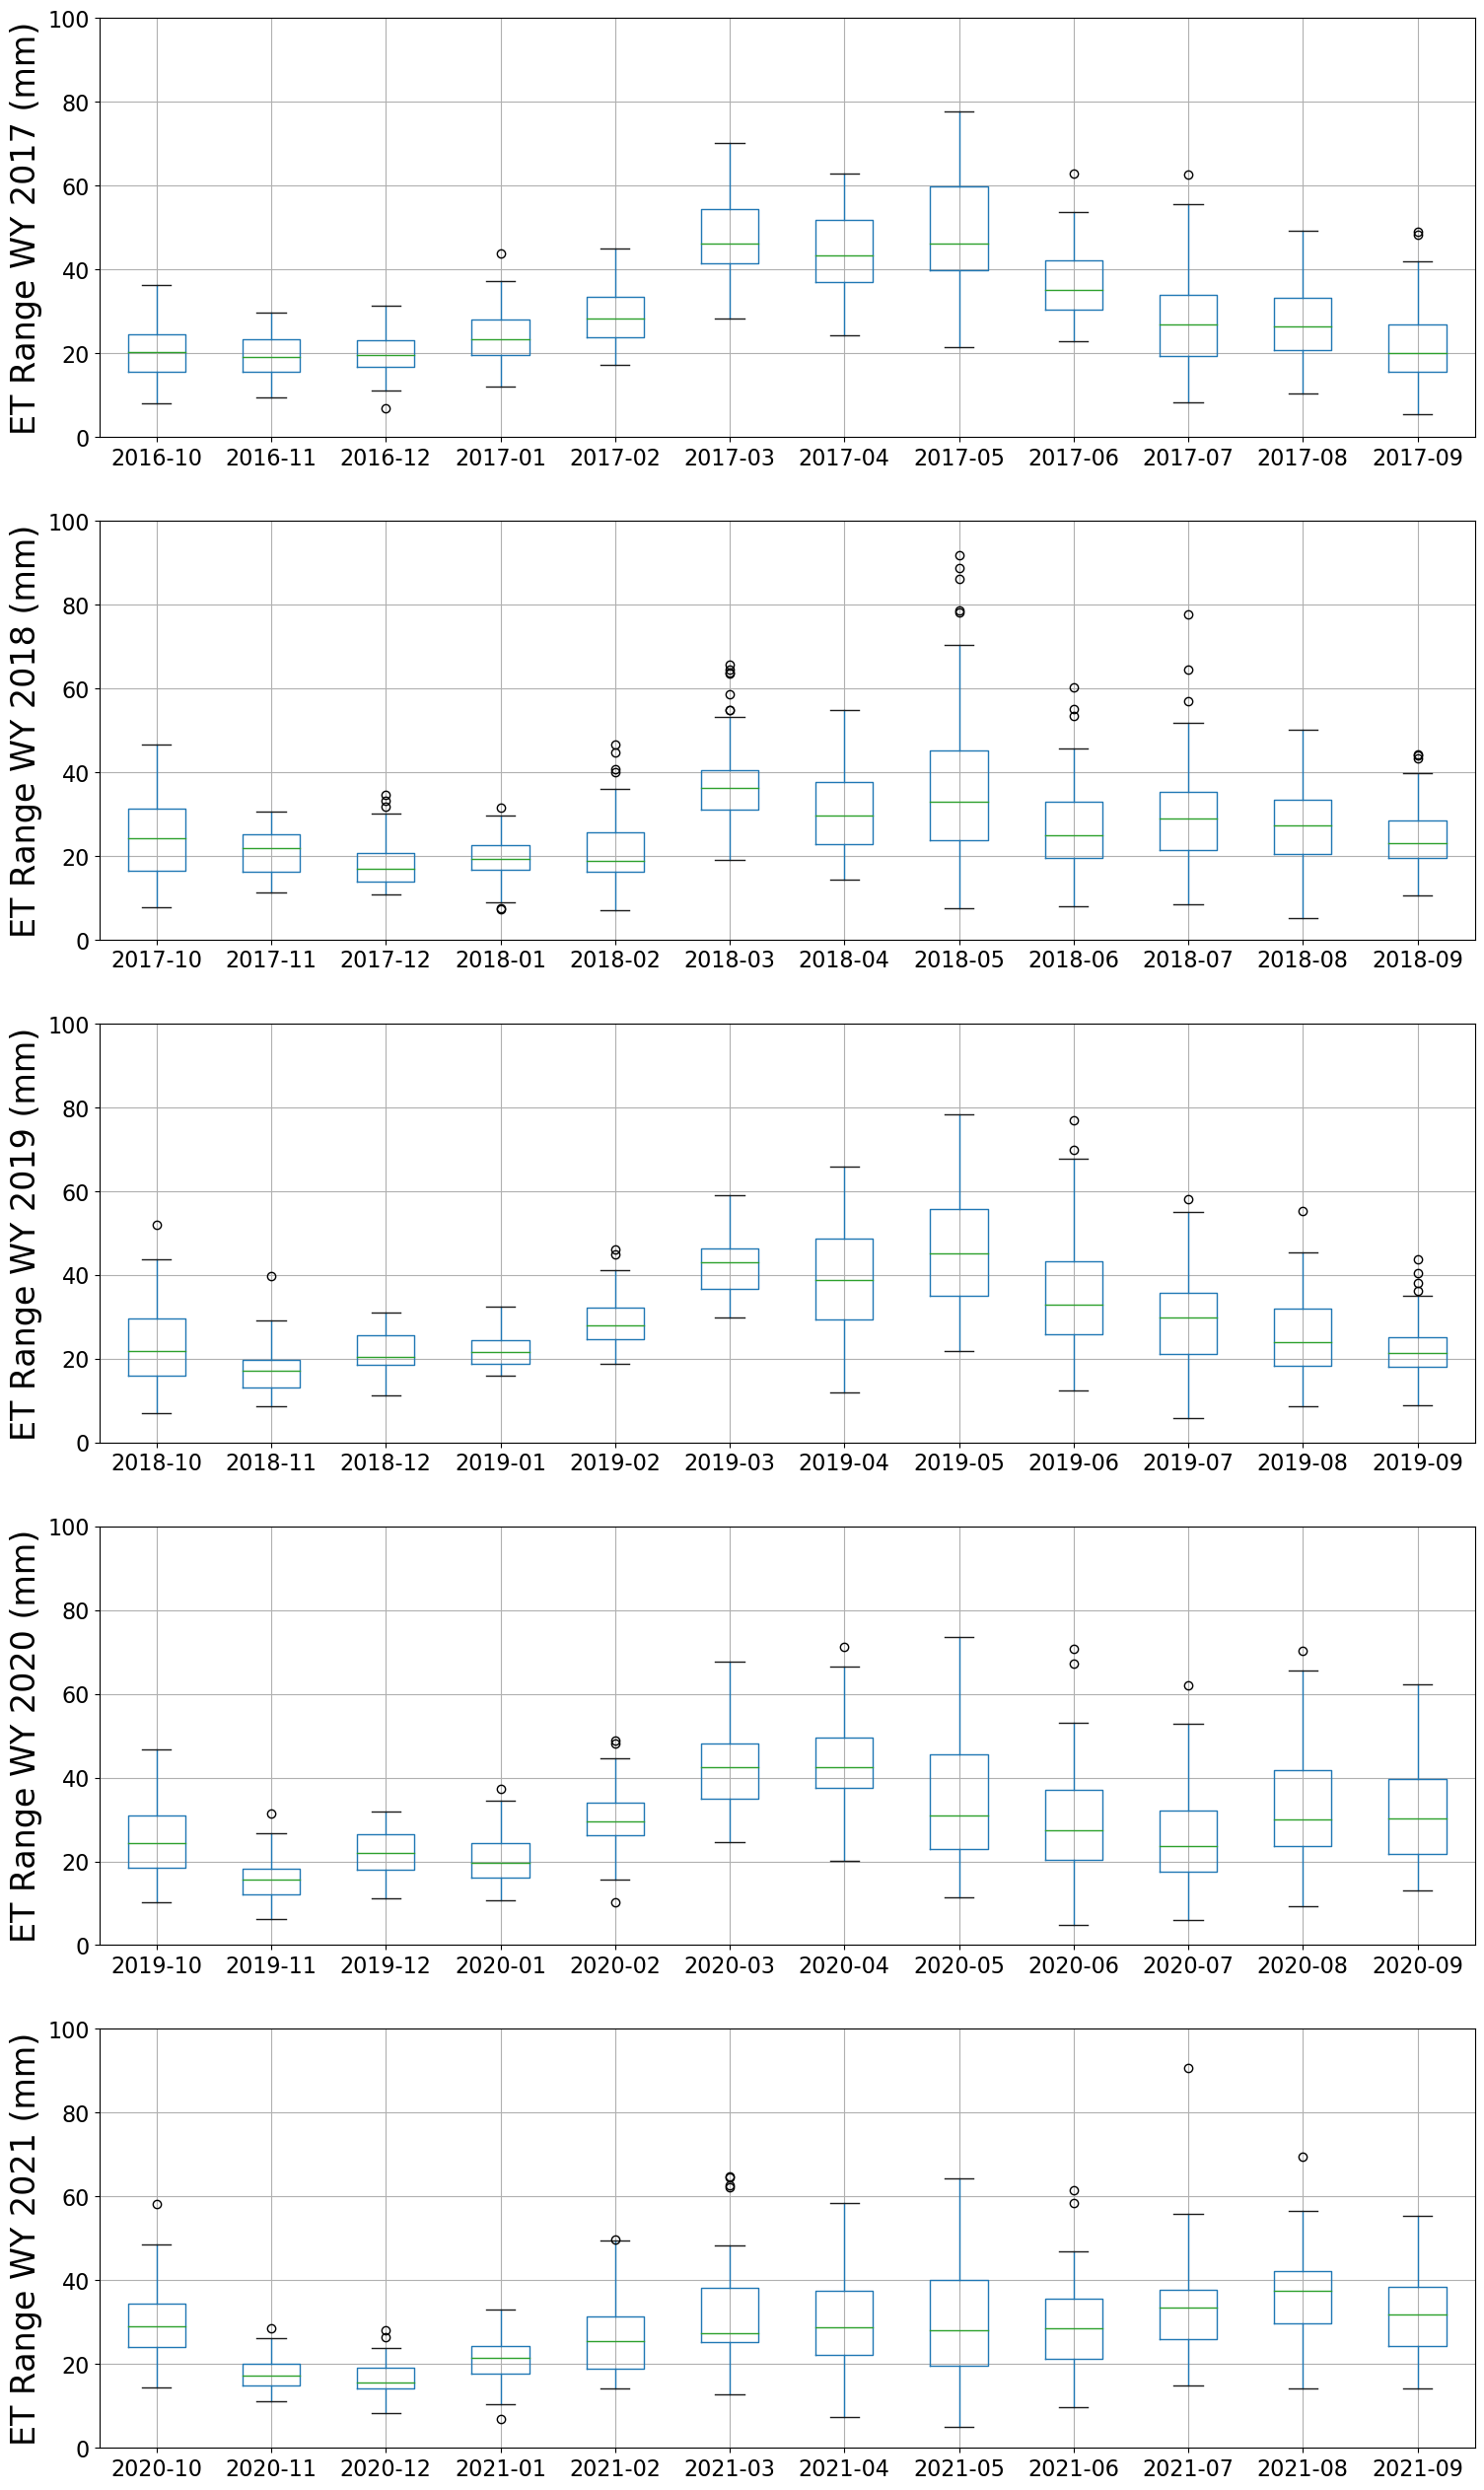

In [78]:
fig, axes = plt.subplots(5,1,figsize=(18,32))
uncertainty_matrix.T.boxplot(row_one, ax = axes[0]) 
axes[0].set_ylim(0,100)
axes[0].tick_params(axis='both', labelsize=16)
axes[0].set_xticklabels(item.get_text()[:7] for item in axes[0].get_xticklabels())
axes[0].set_ylabel("ET Range WY 2017 (mm)", fontsize=24)
uncertainty_matrix.T.boxplot(row_two, ax = axes[1])
axes[1].set_ylim(0,100)
axes[1].tick_params(axis='both', labelsize=16)
axes[1].set_xticklabels(item.get_text()[:7] for item in axes[1].get_xticklabels())
axes[1].set_ylabel("ET Range WY 2018 (mm)", fontsize=24)
uncertainty_matrix.T.boxplot(row_three, ax = axes[2])
axes[2].set_ylim(0,100)
axes[2].tick_params(axis='both', labelsize=16)
axes[2].set_xticklabels(item.get_text()[:7] for item in axes[2].get_xticklabels())
axes[2].set_ylabel("ET Range WY 2019 (mm)", fontsize=24)
uncertainty_matrix.T.boxplot(row_four, ax = axes[3])
axes[3].set_ylim(0,100)
axes[3].tick_params(axis='both', labelsize=16)
axes[3].set_xticklabels(item.get_text()[:7] for item in axes[3].get_xticklabels())
axes[3].set_ylabel("ET Range WY 2020 (mm)", fontsize=24)
uncertainty_matrix.T.boxplot(row_five, ax = axes[4]) 
axes[4].set_ylim(0,100)
axes[4].tick_params(axis='both', labelsize=16)
axes[4].set_xticklabels(item.get_text()[:7] for item in axes[4].get_xticklabels())
axes[4].set_ylabel("ET Range WY 2021 (mm)", fontsize=24)
#uncertainty_matrix.boxplot(row_six, ax = axes[5]) 
#uncertainty_matrix.T.boxplot(row_six, ax = axes[5]) 
#axes[5].set_ylim(0,100)
#axes[5].tick_params(axis='both', labelsize=16)
#axes[5].set_xticklabels(item.get_text()[:7] for item in axes[5].get_xticklabels())

In [79]:
uncertainty_matrix.index
wet_uncertainty_matrix = uncertainty_matrix[uncertainty_matrix.index.month.isin([9,10,11,12,1,2,3,4])]

In [80]:
wet_uncertainty_matrix.mean(axis=0)

25    25.971143
31    32.539484
30    23.209177
24    24.263963
26    30.366288
        ...    
13    27.365947
12    22.042023
15    26.271954
28    28.606791
14    28.052017
Length: 62, dtype: float64

In [81]:
matplotlib.pyplot.rcdefaults()

# Base Graphing Functions, for both slider and gif generation

In [82]:
def cropland_comparison_plot(i_time, matrix, var_name, vmax=150, cmap='viridis', colorbar_title='colorbar',
                             custom_ticks = False, title = 'ET', save_name=None):
    ### Comb through each GSA and get median + uncertainty
    for i in range(len(et_data_file_names)):
        row_id = gsa_cv.index[
                gsa_cv['GSP_ID'] == et_data_file_gsas[i]].tolist()[0]
        gsa_cv.loc[row_id, var_name] = matrix.iloc[i_time,i]
    sample_time = uncertainty_matrix.index[i_time]
    
    ### plot results
    fig, ax = plt.subplots(1,2, figsize = (16,9), subplot_kw={'projection': ccrs.PlateCarree()})
    
    ### ET Data
    staman_image = ax[0].add_image(stamen_terrain, 8)
    gsa_cv.to_crs(4326).boundary.plot(ax=ax[0], color='red', linewidth=1)
    if custom_ticks:
        geo_axes = gsa_cv.to_crs(4326).plot(column=var_name, ax=ax[0], legend=False,
                                       cmap=cmap, vmin=0, vmax=ticks_highest[-1]+0.5)
        cbar = plt.colorbar(geo_axes.collections[-1], ax=ax[0], ticks=ticks_highest)
        cbar.ax.set_yticklabels(colormap_highest)
        cbar.ax.tick_params(labelsize=14)
        if colorbar_title:
            cbar.ax.set_ylabel(colorbar_title, rotation=90, fontsize=16)
    else:
        geo_axes = gsa_cv.to_crs(4326).plot(column=var_name, ax=ax[0], legend=False, vmin=0, vmax=vmax)
        cbar = plt.colorbar(geo_axes.collections[-1], ax=ax[0])
        cbar.ax.tick_params(labelsize=14)
        if colorbar_title:
            cbar.ax.set_ylabel(colorbar_title, rotation=90, fontsize=16)
        #cbar.set_clim(0,vmax)
        
    
    ax[0].set_title(title + str(sample_time.year) + '-' + str(sample_time.month).zfill(2),
                   fontsize=16)
    
    xlim = [-122.83, -118.38]
    ylim = [34.75, 40.75]
    ax[0].set_xticks([-122, -121, -120, -119])
    ax[0].set_yticks([35, 36, 37,38,39,40,41])
    ax[0].set_xlim(xlim)
    ax[0].set_ylim(ylim)
    ax[0].tick_params(axis='both', which='major', labelsize=14)
    ax[0].set_ylabel("Latitude", fontsize=16)
    ax[0].set_xlabel("Longitude", fontsize=16)
    ax[0].axvline(-119.95, color='black', linewidth=2.5)
      
    ### Cropland / Soil Moisture Data
    gsa_cv.to_crs(4326).boundary.plot(ax=ax[1], color='black', linewidth=1)
    cropland_time = math.floor(i_time/12)    
    # this is super jank
    im = cropland_data["cropland"].isel(time=16+cropland_time).plot(ax=ax[1], cmap=cmap_cropland, 
                                                                    add_colorbar=False,
                                                                    vmin=0, vmax=ticks[-1]+0.5)
    cbar = plt.colorbar(im, ax=ax[1], ticks=ticks)
    cbar.ax.set_yticklabels(colormap_labels)
    cbar.ax.tick_params(labelsize=14)
    ax[1].set_xticks([-122, -121, -120, -119])  
    ax[1].set_yticks([35, 36, 37,38,39,40,41])
    ax[1].set_xlim(xlim)
    ax[1].set_ylim(ylim)
    ax[1].tick_params(axis='both', which='major', labelsize=14)
    ax[1].set_ylabel("Latitude", fontsize=16)
    ax[1].set_xlabel("Longitude", fontsize=16)
    ax[1].set_title("Cropland Data Layer: " + str(sample_time.year), fontsize=16)
    plt.tight_layout()
    if save_name:
        plt.savefig(save_name + str(i_time) + '.png', 
                transparent = False,  
                facecolor = 'white'
               )
        plt.close()

done with values


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/Users/mmorphew/opt/an

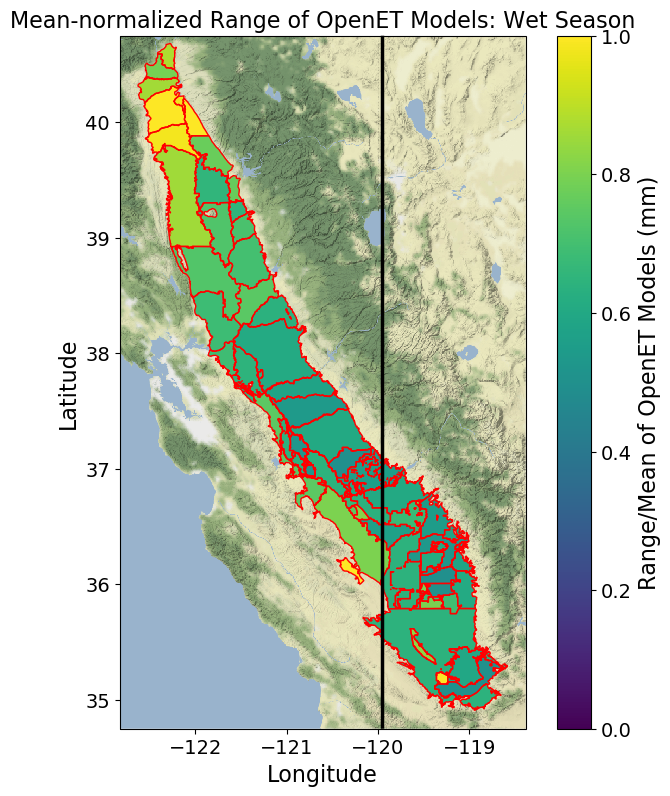

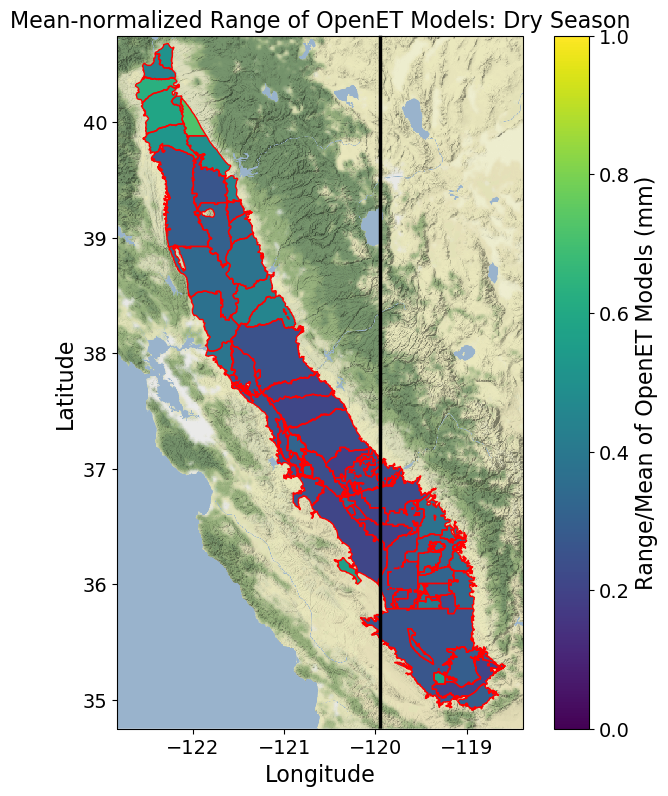

In [89]:
def wet_dry_comparison_plot(matrix, vmax=150, cmap='viridis', colorbar_title='colorbar',
                             custom_ticks = False, title = 'ET', save_name=None):
    ### Comb through each GSA and get median + uncertainty

    matrix = matrix.loc['2016-10-1':'2021-05-01']
    if not custom_ticks:
        wet_matrix = matrix[matrix.index.month.isin([9,10,11,12,1,2,3,4])].mean(axis=0)
        dry_matrix = matrix[matrix.index.month.isin([5,6,7,8])].mean(axis=0)
    else:
        wet_matrix = matrix[matrix.index.month.isin([9,10,11,12,1,2,3,4])].mode(axis=0).dropna().squeeze()
        dry_matrix = matrix[matrix.index.month.isin([5,6,7,8])].mode(axis=0).dropna().squeeze()
    ### Wet October to April
    ### Dry May to September
    for i in range(len(et_data_file_names)):
        row_id = gsa_cv.index[
                gsa_cv['GSP_ID'] == et_data_file_gsas[i]].tolist()[0]
        #gsa_cv.loc[row_id, var_name] = matrix.iloc[i_time,i]
        gsa_cv.loc[row_id, "wet_value"] = wet_matrix[et_data_file_gsas[i]]
        gsa_cv.loc[row_id, "dry_value"] = dry_matrix[et_data_file_gsas[i]]
    
    print('done with values')
    ### plot results

    fig, ax = plt.subplots(1,1, figsize = (8,9), subplot_kw={'projection': ccrs.PlateCarree()})
    
    ### ET Data
    staman_image = ax.add_image(stamen_terrain, 8)
    gsa_cv.to_crs(4326).boundary.plot(ax=ax, color='red', linewidth=1)

    if custom_ticks:
        geo_axes = gsa_cv.to_crs(4326).plot(column="wet_value", ax=ax, legend=False,
                                       cmap=cmap, vmin=0, vmax=vmax)
        cbar = plt.colorbar(geo_axes.collections[-1], ax=ax, ticks=ticks_highest)
        cbar.ax.set_yticklabels(colormap_highest)
        cbar.ax.tick_params(labelsize=14)
        if colorbar_title:
            cbar.ax.set_ylabel(colorbar_title, rotation=90, fontsize=16)
    else:
        geo_axes = gsa_cv.to_crs(4326).plot(column="wet_value", ax=ax, legend=False, vmin=0, vmax=vmax)
        cbar = plt.colorbar(geo_axes.collections[-1], ax=ax)
        cbar.ax.tick_params(labelsize=14)
        if colorbar_title:
            cbar.ax.set_ylabel(colorbar_title, rotation=90, fontsize=16)
        #cbar.set_clim(0,vmax)
        
    
    ax.set_title(title + ': Wet Season',
                   fontsize=16)

    xlim = [-122.83, -118.38]
    ylim = [34.75, 40.75]
    ax.set_xticks([-122, -121, -120, -119])
    ax.set_yticks([35, 36, 37,38,39,40,41])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_ylabel("Latitude", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=16)
    ax.axvline(-119.95, color='black', linewidth=2.5)
    
    ### plot results
    fig, ax = plt.subplots(1,1, figsize = (8,9), subplot_kw={'projection': ccrs.PlateCarree()})
    
    ### ET Data
    staman_image = ax.add_image(stamen_terrain, 8)
    gsa_cv.to_crs(4326).boundary.plot(ax=ax, color='red', linewidth=1)
    if custom_ticks:
        geo_axes = gsa_cv.to_crs(4326).plot(column="dry_value", ax=ax, legend=False,
                                       cmap=cmap, vmin=0, vmax=vmax)
        cbar = plt.colorbar(geo_axes.collections[-1], ax=ax, ticks=ticks_highest)
        cbar.ax.set_yticklabels(colormap_highest)
        cbar.ax.tick_params(labelsize=14)
        if colorbar_title:
            cbar.ax.set_ylabel(colorbar_title, rotation=90, fontsize=16)
    else:
        geo_axes = gsa_cv.to_crs(4326).plot(column="dry_value", ax=ax, legend=False, vmin=0, vmax=vmax)
        cbar = plt.colorbar(geo_axes.collections[-1], ax=ax)
        cbar.ax.tick_params(labelsize=14)
        if colorbar_title:
            cbar.ax.set_ylabel(colorbar_title, rotation=90, fontsize=16)
        #cbar.set_clim(0,vmax)
        
    
    ax.set_title(title + ': Dry Season',
                   fontsize=16)
    
    xlim = [-122.83, -118.38]
    ylim = [34.75, 40.75]
    ax.set_xticks([-122, -121, -120, -119])
    ax.set_yticks([35, 36, 37,38,39,40,41])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_ylabel("Latitude", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=16)
    ax.axvline(-119.95, color='black', linewidth=2.5)
    
    '''
    ### Cropland / Soil Moisture Data
    gsa_cv.to_crs(4326).boundary.plot(ax=ax[1], color='black', linewidth=1)
    cropland_time = math.floor(i_time/12)    
    # this is super jank
    im = cropland_data["cropland"].isel(time=16+cropland_time).plot(ax=ax[1], cmap=cmap_cropland, 
                                                                    add_colorbar=False,
                                                                    vmin=0, vmax=ticks[-1]+0.5)
    cbar = plt.colorbar(im, ax=ax[1], ticks=ticks)
    cbar.ax.set_yticklabels(colormap_labels)
    cbar.ax.tick_params(labelsize=14)
    ax[1].set_xticks([-122, -121, -120, -119])  
    ax[1].set_yticks([35, 36, 37,38,39,40,41])
    ax[1].set_xlim(xlim)
    ax[1].set_ylim(ylim)
    ax[1].tick_params(axis='both', which='major', labelsize=14)
    ax[1].set_ylabel("Latitude", fontsize=16)
    ax[1].set_xlabel("Longitude", fontsize=16)
    ax[1].set_title("Cropland Data Layer: " + str(sample_time.year), fontsize=16)
    plt.tight_layout()
    if save_name:
        plt.savefig(save_name + str(i_time) + '.png', 
                transparent = False,  
                facecolor = 'white'
               )
        plt.close()
    '''
    plt.show

wet_dry_comparison_plot(norm_range_matrix, vmax=1, cmap='viridis', colorbar_title='Range/Mean of OpenET Models (mm)',
                             custom_ticks = False, title = 'Mean-normalized Range of OpenET Models', save_name=None)  

#wet_dry_comparison_plot(max_matrix, vmax=ticks_highest[-1]+0.5, cmap=cmap_highest, colorbar_title=None, 
#                             custom_ticks = True, title = 'OpenET Model with Highest Estimate', save_name=None)  

In [87]:
def soil_moisture_comparison_plot(i_time, matrix, var_name, vmax=150, cmap='viridis', colorbar_title='colorbar',
                             custom_ticks = False, title = 'ET', save_name=None):
    ### Comb through each GSA and get median + uncertainty
    for i in range(len(et_data_file_names)):
        row_id = gsa_cv.index[
                gsa_cv['GSP_ID'] == et_data_file_gsas[i]].tolist()[0]
        gsa_cv.loc[row_id, var_name] = matrix.iloc[i_time,i]
    sample_time = uncertainty_matrix.index[i_time]
    
    ### plot results
    fig, ax = plt.subplots(1,2, figsize = (16,9), subplot_kw={'projection': ccrs.PlateCarree()})
    
    ### ET Data
    staman_image = ax[0].add_image(stamen_terrain, 8)
    gsa_cv.to_crs(4326).boundary.plot(ax=ax[0], color='red', linewidth=1)
    geo_axes = gsa_cv.to_crs(4326).plot(column=var_name, ax=ax[0], legend=False, vmin=0, vmax=vmax,
                                       cmap=cmap)
    
    if custom_ticks:
        cbar = plt.colorbar(geo_axes.collections[-1], ax=ax[0], ticks=ticks_highest, cmap=cmap)
        cbar.ax.set_yticklabels(colormap_highest)
    else:
        cbar = plt.colorbar(geo_axes.collections[-1], ax=ax[0])
        
    cbar.ax.tick_params(labelsize=14)
    if colorbar_title:
        cbar.ax.set_ylabel(colorbar_title, rotation=90, fontsize=16)
    ax[0].set_title(title + str(sample_time.year) + '-' + str(sample_time.month),
                   fontsize=16)
    
    xlim = [-122.83, -118.38]
    ylim = [34.75, 40.75]
    ax[0].set_xticks([-122, -121, -120, -119])
    ax[0].set_yticks([35, 36, 37,38,39,40,41])
    ax[0].set_xlim(xlim)
    ax[0].set_ylim(ylim)
    ax[0].tick_params(axis='both', which='major', labelsize=14)
    ax[0].set_ylabel("Latitude", fontsize=16)
    ax[0].set_xlabel("Longitude", fontsize=16)
    ax[0].axvline(-119.95, color='black', linewidth=2.5)
      
    ### Cropland / Soil Moisture Data
    gsa_cv.to_crs(4326).boundary.plot(ax=ax[1], color='black', linewidth=1)
    cropland_time = math.floor(i_time/12)    
    # this is super jank
    im = total_soil_moisture_data["sm"].isel(time=i_time).plot(ax=ax[1], cmap='viridis', 
                                                                    add_colorbar=False,
                                                                    vmin=0, vmax=150)
    cbar = plt.colorbar(im, ax=ax[1])
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_ylabel("Soil Moisture (mm)", rotation=90, fontsize=16)
    ax[1].set_xticks([-122, -121, -120, -119])  
    ax[1].set_yticks([35, 36, 37,38,39,40,41])
    ax[1].set_xlim(xlim)
    ax[1].set_ylim(ylim)
    ax[1].tick_params(axis='both', which='major', labelsize=14)
    ax[1].set_ylabel("Latitude", fontsize=16)
    ax[1].set_xlabel("Longitude", fontsize=16)
    ax[1].set_title("Soil Moisture Data: " + str(sample_time.year) + '-' + str(sample_time.month), fontsize=16)
    plt.tight_layout()
    if save_name:
        plt.savefig(save_name + str(i_time) + '.png', 
                transparent = False,  
                facecolor = 'white'
               )
        plt.close()

In [ ]:
matplotlib.rc_file_defaults()

# Slider Plots, load times are tied to the cholorpleth and cropland plots, so it's not easy to speed this up, just gotta wait 10ish seconds for it to load

In [151]:
def slider_plot_et_uncertainty(i_time):
    cropland_comparison_plot(i_time=i_time, matrix=norm_range_matrix, var_name='variance', 
                             vmax=1, cmap='viridis', colorbar_title="ET Model Mean-Normalized Range",
                             custom_ticks = False, title = "ET Model Mean-Normalized Range: ")
interact(slider_plot_et_uncertainty, i_time = widgets.IntSlider(min=0, max=59, step=1))

interactive(children=(IntSlider(value=0, description='i_time', max=59), Output()), _dom_classes=('widget-inter…

<function __main__.slider_plot_et_uncertainty(i_time)>

In [478]:
def slider_plot_et_mean(i_time):
    cropland_comparison_plot(i_time=i_time, matrix=mean_matrix, var_name='mean', 
                             vmax=150, cmap='viridis', colorbar_title="Mean of ET Models (mm)",
                             custom_ticks = False, title = "Mean of ET Models: ")
interact(slider_plot_et_mean, i_time = widgets.IntSlider(min=0, max=59, step=1))

interactive(children=(IntSlider(value=0, description='i_time', max=59), Output()), _dom_classes=('widget-inter…

<function __main__.slider_plot_et_mean(i_time)>

In [80]:
def slider_plot_et_highest(i_time):
    cropland_comparison_plot(i_time=i_time, matrix=max_matrix, var_name='max_model', 
                             vmax=ticks_highest[-1]+0.5, cmap=cmap_highest, 
                             colorbar_title=None, custom_ticks=True,
                             title = "Highest Estimate ET Model: ")
interact(slider_plot_et_highest, i_time = widgets.IntSlider(min=0, max=59, step=1))

interactive(children=(IntSlider(value=0, description='i_time', max=59), Output()), _dom_classes=('widget-inter…

<function __main__.slider_plot_et_highest(i_time)>

In [372]:
def create_cropland_comparison_gif(matrix, var_name, save_name, gif_name, vmax=150, 
                                   cmap='viridis', colorbar_title='colorbar', 
                                   custom_ticks = False, title = 'ET'):
    for i_time in range(60):
        print("creating plot number: ", i_time)
        cropland_comparison_plot(i_time=i_time, matrix=matrix, var_name=var_name, 
                             vmax=vmax, cmap=cmap, 
                             colorbar_title=colorbar_title, custom_ticks=custom_ticks,
                             title = title, save_name=save_name)
    
    #frames = []
    #for i_time in range(60):
    #    image = imageio.imread(save_name + str(i_time) + '.png')
    #    frames.append(image)
    #imageio.mimsave(gif_name, # output gif
    #                frames,          # array of input frames
    #                fps = 2)         # optional: frames per second
    fns_image=glob.glob(save_name+'*')
    fns_image.sort()
    img, *imgs = [Image.open(f) for f in fns_image]
    img.save(fp=gif_name, format='GIF', append_images=imgs,
     save_all=True, duration=500, loop=0)

In [125]:
create_cropland_comparison_gif(min_matrix, "min_model", '../images/img_lowest_gsp', 
                               '../images/example_lowest_gsp.gif', vmax=ticks_highest[-1]+0.5,
                              cmap=cmap_highest, custom_ticks = True, title= 'Lowest Estimate ET Model: ')

creating plot number:  0


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  1


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  2


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  3


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  4


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  5


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  6


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  7


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  8


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  9


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  10


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  11


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  12


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  13


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  14


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  15


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  16


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  17


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  18


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  19


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  20


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  21


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  22


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  23


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  24


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  25


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  26


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  27


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  28


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  29


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  30


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  31


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  32


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  33


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  34


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  35


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  36


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  37


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  38


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  39


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  40


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  41


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  42


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  43


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  44


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  45


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  46


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  47


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  48


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  49


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  50


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  51


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  52


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  53


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  54


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  55


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  56


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  57


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  58


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  59


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


In [394]:
create_cropland_comparison_gif(norm_range_matrix, "norm_range", '../images/img_norm_range_gsp_', 
                               '../images/example_norm_range_gsp.gif', vmax=2, 
                               colorbar_title="OpenET Mean-Normalized Model Range",
                              cmap='viridis', custom_ticks = False, title= "OpenET Mean-Normalized Model Range: ")

creating plot number:  0


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  1


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  2


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  3


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  4


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  5


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  6


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  7


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  8


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  9


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  10


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  11


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  12


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  13


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  14


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  15


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  16


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  17


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  18


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  19


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  20


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  21


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  22


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  23


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  24


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  25


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  26


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  27


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  28


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  29


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  30


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  31


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  32


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  33


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  34


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  35


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  36


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  37


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  38


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  39


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  40


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  41


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  42


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  43


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  44


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  45


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  46


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  47


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  48


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  49


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  50


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  51


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  52


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  53


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  54


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  55


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  56


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  57


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  58


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


creating plot number:  59


/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/mmorphew/opt/anaconda3/envs/elev/lib/python3.6/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


In [ ]:
frames = []
for i_time in range(59):
    image = imageio.imread('../images/img_range_gsp_' + str(i_time) + '.png')
    frames.append(image)
imageio.mimsave('../images/example_range_gsp.gif', # output gif
                frames,          # array of input frames
                fps = 2)         # optional: frames per second

In [ ]:
frames = []
for i_time in range(59):
    image = imageio.imread('../images/img_mean_gsp' + str(i_time) + '.png')
    frames.append(image)
imageio.mimsave('../images/example_mean_gsp.gif', # output gif
                frames,          # array of input frames
                fps = 2)         # optional: frames per second

In [ ]:
frames = []
for i_time in range(59):
    image = imageio.imread('../images/img_highest_gsp_' + str(i_time) + '.png')
    frames.append(image)
imageio.mimsave('../images/example_highest_gsp.gif', # output gif
                frames,          # array of input frames
                fps = 2)         # optional: frames per second

# OLD

In [ ]:
fig = plt.figure(figsize = (14,9))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_image(stamen_terrain, 8)
@widgets.interact(i_time=(0, 59, 1))
def update(i_time=0):
    """Remove old lines from plot and plot new one"""
    for i in range(len(et_data_file_names)):
        sample_file = pd.read_csv(et_data_file_names[i], parse_dates=['time'])
        sample_file['et_ensemble_variance'] = sample_file['et_ensemble_mad_max'] - sample_file['et_ensemble_mad_min']
        sample_file_non_nan = sample_file[sample_file['et_ensemble_variance'].notnull()]
        sample_file_non_nan_index = sample_file.index[sample_file['et_ensemble_variance'].notnull()]
        try:
            sample_file_sample_value = (sample_file_non_nan['et_ensemble_variance'][sample_file_non_nan_index[i_time]])
            row_id = gsa_cv_cleaned_no_small.index[
                gsa_cv_cleaned_no_small['GSA_ID'] == et_data_file_gsas[i]].tolist()[0]
            gsa_cv_cleaned_no_small.loc[row_id, 'variance'] = (sample_file_sample_value 
                                                              / gsa_cv_cleaned_no_small.loc[row_id, 'ShapeSTAre'])
        except:
            continue
    sample_time = sample_file['time'][sample_file_non_nan_index[i_time]]
    gsa_cv_cleaned_no_small.plot(column='variance', ax=ax, legend=True, vmin=0, vmax=3e-11,
                                 legend_kwds={'label': "ET Uncertainty (mm/km^2)",
                                'orientation': "vertical"})
    plt.show()

In [ ]:
for j in range(60):
    print(j)
    for i in range(len(et_data_file_names)):
        sample_file = pd.read_csv(et_data_file_names[i], parse_dates=['time'])
        sample_file['et_ensemble_variance'] = sample_file['et_ensemble_mad_max'] - sample_file['et_ensemble_mad_min']
        sample_file_non_nan = sample_file[sample_file['et_ensemble_variance'].notnull()]
        sample_file_non_nan_index = sample_file.index[sample_file['et_ensemble_variance'].notnull()]
        try:
            sample_file_sample_value = (sample_file_non_nan['et_ensemble_variance'][sample_file_non_nan_index[j]])
            row_id = gsa_cv_cleaned_no_small.index[
                gsa_cv_cleaned_no_small['GSA_ID'] == et_data_file_gsas[i]].tolist()[0]
            gsa_cv_cleaned_no_small.loc[row_id, 'variance'] = (sample_file_sample_value 
                                                              / gsa_cv_cleaned_no_small.loc[row_id, 'ShapeSTAre'])
        except:
            continue
    fig, ax = plt.subplots(1,1,figsize=(12,12))
    gsa_cv_cleaned_no_small.boundary.plot(ax=ax)
    cx.add_basemap(ax)
    asset = gsa_cv_cleaned_no_small.plot(column='variance', ax=ax, legend=True)

In [ ]:
print(gsa_cv_cleaned_no_small['variance'].max())

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,12))
gsa_cv_cleaned_no_small.boundary.plot(ax=ax)
asset = gsa_cv_cleaned_no_small.plot(column='variance', ax=ax, legend=True)

In [ ]:
for i in range(len(et_data_file_names)):
    sample_file = pd.read_csv(et_data_file_names[i], parse_dates=['time'])

    sample_file_non_nan = sample_file[sample_file['et_ensemble_mad'].notnull()]
    sample_file_non_nan_index = sample_file.index[sample_file['et_ensemble_mad'].notnull()]
    try:
        sample_file_sample_value = (sample_file_non_nan['et_ensemble_mad'][sample_file_non_nan_index[4]])
        row_id = gsa_cv_cleaned_no_small.index[
            gsa_cv_cleaned_no_small['GSA_ID'] == et_data_file_gsas[i]].tolist()[0]
        row_area = gsa_cv_cleaned_no_small.loc[row_id].geometry.area * 1e-6
        gsa_cv_cleaned_no_small.loc[row_id, 'median'] = (sample_file_sample_value)
    except:
        continue

In [ ]:
gsa_cv_cleaned_no_small[gsa_cv_cleaned_no_small['GSA_Name']=='Wyandotte Creek GSA']

In [ ]:
@widgets.interact(i_time=(0, 59, 1))
def update(i_time=0):
    """Remove old lines from plot and plot new one"""
    for i in range(len(et_data_file_names)):
        sample_file = pd.read_csv(et_data_file_names[i], parse_dates=['time'])
        sample_file['et_ensemble_variance'] = sample_file['et_ensemble_mad_max'] - sample_file['et_ensemble_mad_min']
        sample_file_non_nan = sample_file[sample_file['et_ensemble_variance'].notnull()]
        sample_file_non_nan_index = sample_file.index[sample_file['et_ensemble_variance'].notnull()]
        try:
            sample_file_sample_value = (sample_file_non_nan['et_ensemble_variance'][sample_file_non_nan_index[i_time]])
            row_id = gsa_cv_cleaned_no_small.index[
                gsa_cv_cleaned_no_small['GSA_ID'] == et_data_file_gsas[i]].tolist()[0]
            gsa_cv_cleaned_no_small.loc[row_id, 'variance'] = (sample_file_sample_value 
                                                              / gsa_cv_cleaned_no_small.loc[row_id, 'ShapeSTAre'])
        except:
            continue
    sample_time = sample_file['time'][sample_file_non_nan_index[i_time]]
    gsa_cv_cleaned_no_small.plot(column='variance', ax=ax, legend=True, vmin=0, vmax=3e-11,
                                 legend_kwds={'label': "ET Uncertainty (mm/km^2)",
                                'orientation': "vertical"})
    plt.show()

In [ ]:
fig = plt.figure(figsize = (14,9))
ax = plt.axes(projection=ccrs.PlateCarree())

# Get some 
cv_shape.to_crs(4326, inplace=True)
crs= cv_shape.to_crs(4326)

imextent = cv_shape.bounds


lllon, lllat = imextent.minx.values[0], imextent.miny.values[0]
urlon, urlat = imextent.maxx.values[0], imextent.maxy.values[0]

print(lllon, lllat)
print(urlon, urlat)
ax.set_extent([lllon-.25, urlon+.25, lllat-.25, urlat+.25])

# Create a Stamen Terrain instance.

stamen_terrain
# Create a GeoAxes in the tile's projection.
#gl = ax.gridlines(draw_labels=True)
#gl.top_labels= False
#gl.right_labels = False

#gl.xlocator = mticker.FixedLocator(np.linspace(-180,180,1441))
#gl.ylocator = mticker.FixedLocator(np.linspace(0,90,721))
#gl.xformatter = LONGITUDE_FORMATTER
#gl.yformatter = LATITUDE_FORMATTER
#gl.xlabel_style = {'size': 9, 'color': 'gray'}
#gl.ylabel_style = {'size': 9, 'color': 'gray'}

#gsa_cv_cleaned_no_small.to_crs(4326).boundary.plot(ax=ax)
gsa_boundaries = ShapelyFeature(gsa_cv_cleaned_no_small.to_crs(4326).geometry.values,
                        ccrs.PlateCarree(), edgecolor='blue', facecolor = 'none', linewidth = 2)
ax.add_image(stamen_terrain, 8)
ax.add_feature(gsa_boundaries)
ax.set_aspect('auto')

@widgets.interact(i_time=(0, 59, 1))
def update(i_time=0):
    for i in range(len(et_data_file_names)):
        sample_file = pd.read_csv(et_data_file_names[i], parse_dates=['time'])
        sample_file['et_ensemble_variance'] = sample_file['et_ensemble_mad_max'] - sample_file['et_ensemble_mad_min']
        sample_file_non_nan = sample_file[sample_file['et_ensemble_variance'].notnull()]
        sample_file_non_nan_index = sample_file.index[sample_file['et_ensemble_variance'].notnull()]
        try:
            sample_file_sample_value = (sample_file_non_nan['et_ensemble_variance'][sample_file_non_nan_index[i_time]])
            row_id = gsa_cv_cleaned_no_small.index[
                gsa_cv_cleaned_no_small['GSA_ID'] == et_data_file_gsas[i]].tolist()[0]
            gsa_cv_cleaned_no_small.loc[row_id, 'variance'] = (sample_file_sample_value 
                                                              / gsa_cv_cleaned_no_small.loc[row_id, 'ShapeSTAre'])
        except:
            continue
    sample_time = sample_file['time'][sample_file_non_nan_index[i_time]]
    gsa_cv_cleaned_no_small.plot(column='variance', ax=ax, legend=True, vmin=0, vmax=3e-11,
                                 legend_kwds={'label': "ET Uncertainty (mm/km^2)",
                                'orientation': "vertical"})
    plt.show()

